<a href="https://colab.research.google.com/github/fcignoli/Redes-Complejas-2-20222/blob/main/TPC05_Comunidades_Ejercicio1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comunidades. Ejercicio 1: Red de Delfines.




##Carga de datos, funciones y demases

In [43]:
# Primero, uso de los códigos subidos al cuaderno colaborativo para conseguir los datos del ejercicio
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile

url = "http://materias.df.uba.ar/rca2022c2/files/2022/10/TC05_ComunidadesData.zip"
with urlopen(url) as zipresp:
    with ZipFile(BytesIO(zipresp.read())) as zfile:
       archivos = zfile.namelist()
       for archivo in archivos:
           if archivo.endswith('.txt') or archivo.endswith('.gml') or archivo.endswith('.csv'):
               zfile.extract(archivo, '/content')

!pip install bbox
!apt-get install libcairo2-dev libjpeg-dev libgif-dev
!pip install pycairo
!pip install igraph
!pip install python-louvain

import networkx as nx
import numpy as np
import matplotlib.pylab as plt
import igraph as ig
from community import community_louvain as com
import cairo # Importo Cairo
import bbox
from functools import reduce
import operator as op
from sklearn.metrics import normalized_mutual_info_score as nmis
# Esto es para que funcione Cairo
from google.colab import files
from IPython.display import SVG, display, Image
import seaborn as sns
sns.set_theme(style="darkgrid")
def show_svg(file):
    display(SVG(filename=file))

# Función para llevar el objeto vertex cluster a diccionario
def cluster_to_dict(cluster, g):
    dic = {}
    for i, c in enumerate(sorted(list(cluster), key = len, reverse = True)):
        for n in c:
            dic[g.vs[n]['_nx_name']] = i
    return dic

#Definamos una función que, dada una red y una partición, nos devuelva un plot del clustering de cada nodo
def silhouette(Red,particion): # La función nos pide la Red y la partición como diccionario
  S=[]
  limites=[0]
  # Recorro los clusters sin repetir
  for cluster in set(particion.values()): 
    #Filtro los nodos que pertenecen a este cluster
    nodos_en_cluster = [nodo for (nodo, value) in particion.items() if value == cluster] 
    S_cluster=[]
    # Recorro los nodos del cluster
    for nodo in nodos_en_cluster:
      distancias_dentro=[]
      distancias_fuera=[]
      # Recorro los nodos del mismo cluster
      for nodo_en_cluster in nodos_en_cluster:
        if nodo != nodo_en_cluster:
          # Calculo y guardo la distancia, si no es consigo mismo
          distancias_dentro.append(nx.shortest_path_length(Red, source=nodo, target=nodo_en_cluster, weight=None))
      # Recorro los nodos de los otros clusters
      for nodo_fuera in Red.nodes():
        if particion[nodo_fuera] != cluster:
          # Calculo y guardo la distancia
          distancias_fuera.append(nx.shortest_path_length(Red, source=nodo, target=nodo_fuera, weight=None)) 
      # Calculo la distancia media para los del mismo cluster
      distancia_media_dentro = np.mean(distancias_dentro)
      # Calculo la distancia mínima para los nodos fuera del cluster
      distancia_mean_fuera = np.mean(distancias_fuera)
      # Calculo y guardo la Silhouette del nodo
      S_cluster.append((distancia_mean_fuera - distancia_media_dentro)/np.max([distancia_mean_fuera,distancia_media_dentro]))
    # Ordeno las Silhouette del mismo cluster por valor, para graficar lindo
    S_cluster=sorted(S_cluster)
    # Me guardo en qué nodo termina cada cluster, para graficar clusters por colores
    limites.append(len(S_cluster)+limites[-1])
    # Agrego las Silhouette de este cluster a la lista de todas
    S = S + S_cluster
  # Calculo la Silhouette media
  S_media = np.mean(S)
  # Grafico todas con colores por clusters
  for i in range(len(limites)-1):
    plt.barh(range(limites[i],limites[i+1]), S[limites[i]:limites[i+1]])
#    plt.plot(range(limites[i],limites[i+1]),S[limites[i]:limites[i+1]])
  plt.axvline(S_media)
  return S, S_media

#la vieja y querida abrir txt
def abrir_txt(nombre_archivo):
    archivo=open(nombre_archivo)
    data=[]
    for linea in archivo:
        linea=linea.strip()
        columna=linea.split()
        data.append(columna)
    return data

#dos funciones para el ultimo item.
#combinatoria
def ncr(n, r):
    r = min(r, n-r)
    numer = reduce(op.mul, range(n, n-r, -1), 1)
    denom = reduce(op.mul, range(1, r+1), 1)
    return numer/denom
#probabilidad
def proba(a,b,tot,tot_M,tot_H):
    p=0
    #if a != 0:
    #  if b != 0:
    p=(ncr(tot_M,a))*(ncr(tot_H,b))/(ncr(tot,a+b)) 
    return p

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libjpeg-dev is already the newest version (8c-2ubuntu8).
libcairo2-dev is already the newest version (1.15.10-2ubuntu0.1).
libgif-dev is already the newest version (5.1.4-2ubuntu0.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 22 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Cargado de los datos: Red de Delfines


In [44]:
G = nx.read_gml('/content/dolphins.gml')

1)Considere la red social de 62 delfines de Nueva Zeland

Encuentre la partición en comunidades de esta red utilizando la metodología Louvain, infomap, fast_greedyy edge_betweenness. Visualice los resultados gráficamente.

In [45]:
# Fastgreedy y Betweenness

G_ig = ig.Graph.from_networkx(G)

com_bt = G_ig.community_edge_betweenness(clusters = None, directed = False, weights = None)
com_fg = G_ig.community_fastgreedy(weights = None)


print('Betweenness')
print(com_bt) # Cantidad de elementos y de mergeos hechos
print(f'La cantidad de comunas que maximiza la modularidad es: {com_bt.optimal_count}')
print(f'La modularidad de dicha partición es: {com_bt.as_clustering().modularity}')
print(f'La separación en comunas, considerando 5 comunidades es: \n {com_bt.as_clustering()}')
print('------------------------------------------------------')
print('Fastgreedy')
print(com_fg) # Cantidad de elementos y de mergeos hechos
print(f'La cantidad de comunas que maximiza la modularidad es: {com_fg.optimal_count}')
print(f'La modularidad de dicha partición es: {com_fg.as_clustering().modularity}')
print(f'La separación en comunas, considerando 5 comunidades es: \n {com_fg.as_clustering()}')
print('------------------------------------------------------')
# Infomap
com_ip = G_ig.community_infomap()
print('Infomap')
print(com_ip)
print('------------------------------------------------------')
#Louvain
com_lv = com.best_partition(G)
print('----------------------')
print(com_lv) # Es un diccionario!
print(f'La modularidad de esta partición es: {com.modularity(com_lv, G)}')

Betweenness
Dendrogram, 62 elements, 61 merges
La cantidad de comunas que maximiza la modularidad es: 5
La modularidad de dicha partición es: 0.5193821446936435
La separación en comunas, considerando 5 comunidades es: 
 Clustering with 62 elements and 5 clusters
[0] 0, 2, 10, 28, 30, 42, 47
[1] 1, 5, 6, 7, 9, 13, 17, 19, 22, 25, 26, 27, 31, 32, 39, 41, 48, 54, 56, 57,
    60
[2] 3, 8, 12, 14, 16, 20, 33, 34, 36, 37, 38, 40, 43, 44, 46, 49, 50, 52, 58,
    59
[3] 4, 11, 15, 18, 21, 23, 24, 29, 35, 45, 51, 55
[4] 53, 61
------------------------------------------------------
Fastgreedy
Dendrogram, 62 elements, 61 merges
La cantidad de comunas que maximiza la modularidad es: 4
La modularidad de dicha partición es: 0.4954906847039279
La separación en comunas, considerando 5 comunidades es: 
 Clustering with 62 elements and 4 clusters
[0] 0, 2, 10, 12, 14, 16, 20, 33, 34, 37, 38, 40, 42, 43, 44, 46, 47, 49, 50,
    52, 53, 58, 61
[1] 1, 5, 6, 7, 9, 13, 17, 19, 22, 25, 26, 27, 28, 30, 31, 32,

### Visualización mediante dendrograma
Sólo apta para las que nos devuelven distintos niveles de granularidad

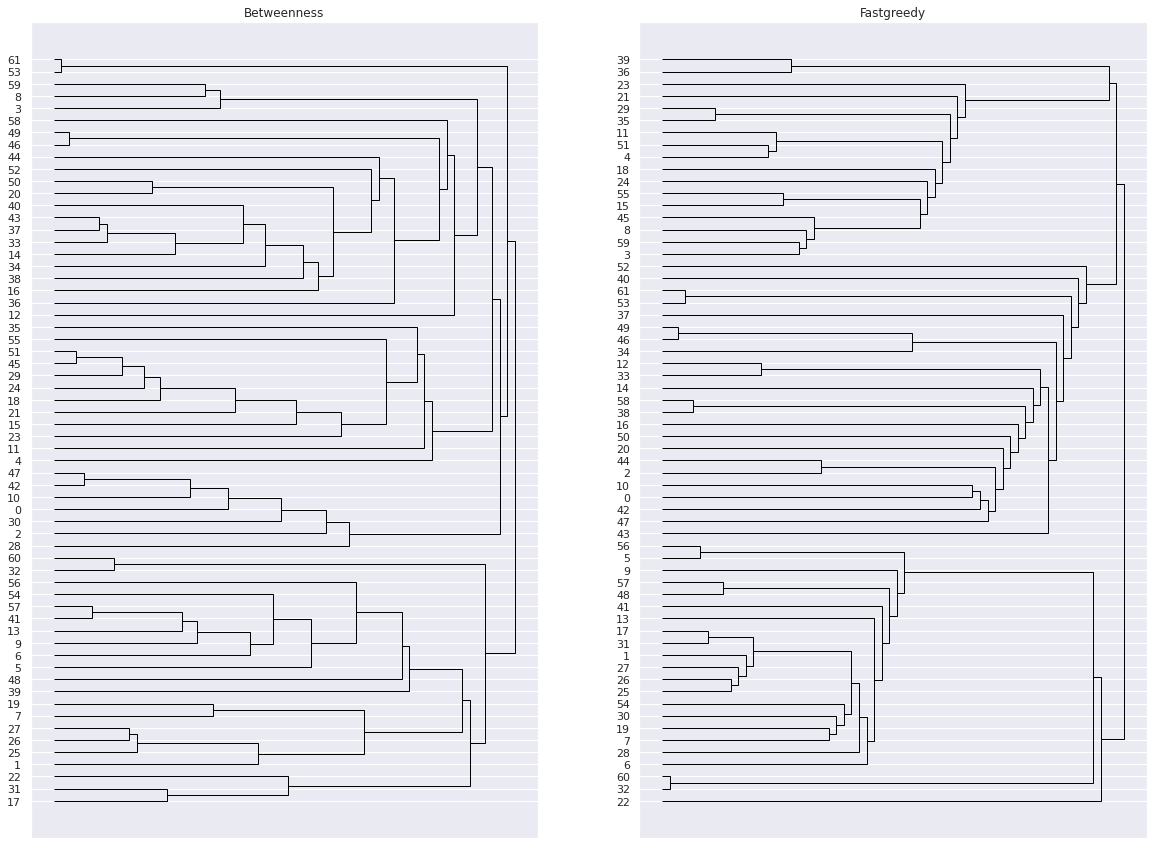

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(20, 15))
com_bt.__plot__('matplotlib', ax[0]) 
com_fg.__plot__('matplotlib', ax[1])
ax[0].set_title('Betweenness')
ax[1].set_title('Fastgreedy')
plt.show()

### Visualización de la red

Colorear por colores cada comuna y así ver en "simultáneo" varias particiones

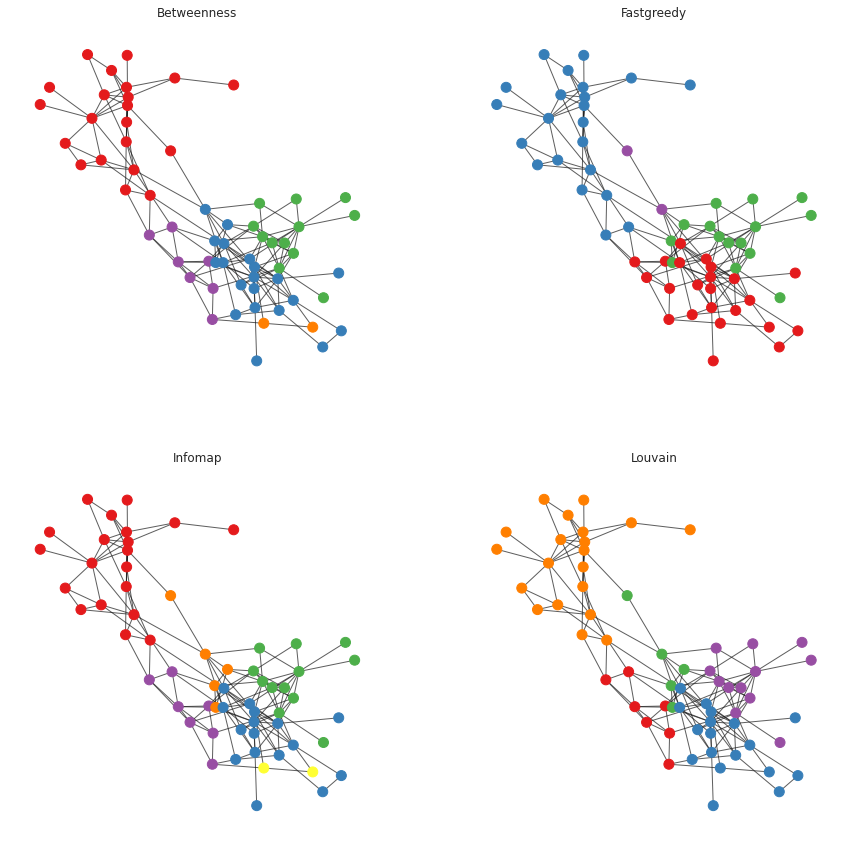

In [47]:
pos = nx.layout.fruchterman_reingold_layout(G)

dic_com_bt = cluster_to_dict(com_bt.as_clustering(), G_ig)
dic_com_fg = cluster_to_dict(com_fg.as_clustering(), G_ig)
dic_com_ip = cluster_to_dict(com_ip, G_ig)
particiones = [dic_com_bt, dic_com_fg, dic_com_ip, com_lv]
nombres=['Betweenness', 'Fastgreedy', 'Infomap', 'Louvain']

fig, axs = plt.subplots(2, 2, figsize = (15, 15))

for i, ax in enumerate(fig.axes):
    nx.draw_networkx_nodes(G,
                           pos = pos,
                           node_color = [plt.get_cmap('Set1')(particiones[i][v]) for v in G.nodes()],
                           ax = ax,
                           node_size = 100)
    nx.draw_networkx_edges(G,
                           pos = pos,
                           ax = ax,
                           alpha = .7)
    ax.axis('off')
    ax.set_title(nombres[i]) #agreguemos un cartelito que diga cual es cual

plt.show()

##b)Caracterice las particiones obtenidas en términos de modularidad y silouhette score. Compare los valores esperados en redes recableadas y establezca si tiene derecho a llamar modular a esta red.

 # Sillhouette 

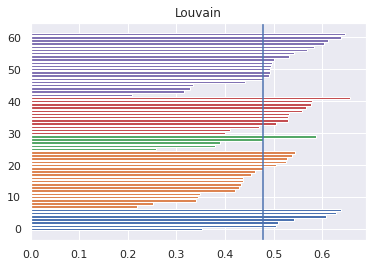

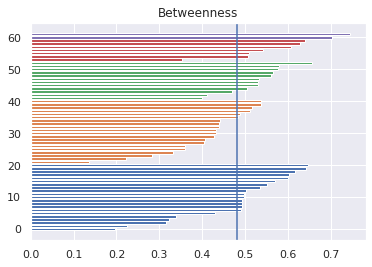

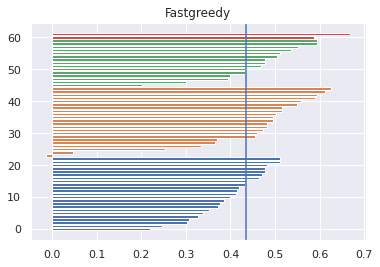

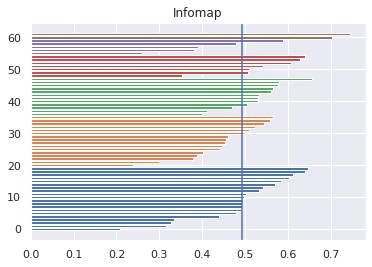

In [48]:

s, s_media = silhouette(G, com_lv)
plt.title(nombres[3])
plt.show()
s, s_media = silhouette(G, dic_com_bt)
plt.title(nombres[0])
plt.show()
s, s_media = silhouette(G, dic_com_fg)
plt.title(nombres[1])
plt.show()
s, s_media = silhouette(G, dic_com_ip)
plt.title(nombres[2])
plt.show()


Todas las comunidades estan por arriba de la media, así que entendemos que esta correcto.

In [49]:
modularidad_bt_real=com_bt.as_clustering().modularity
modularidad_fg_real=com_fg.as_clustering().modularity
modularidad_ip_real=com_ip.modularity
modularidad_lv_real=com.modularity(com_lv, G)

print('Modularidades')
print('La modularidad Betweenness es',modularidad_bt_real)
print('La modularidad Fastgreedy es',modularidad_fg_real)
print('La modularidad Infomap es',modularidad_ip_real)
print('La modularidad Louvain es',modularidad_lv_real)

Modularidades
La modularidad Betweenness es 0.5193821446936435
La modularidad Fastgreedy es 0.4954906847039279
La modularidad Infomap es 0.5247419010323958
La modularidad Louvain es 0.5277283335311103


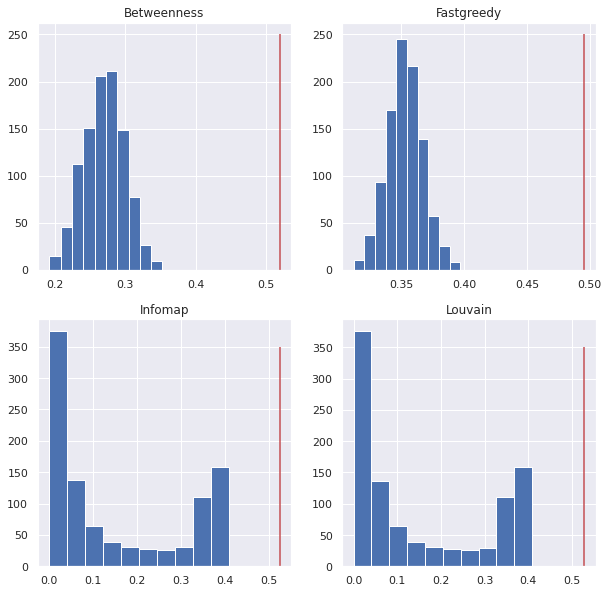

In [50]:
#recabliemos la red y veamos si estos valores son altos o bajos
modularidad_bt=[]
modularidad_fg=[]
modularidad_ip=[]
modularidad_lv=[]
#recabliemos 1000 veces
for i in np.linspace(0,1000,1000):
  F=nx.random_reference(G)
  F_ig = ig.Graph.from_networkx(F)
  com_ip = F_ig.community_infomap()
  com_bt = F_ig.community_edge_betweenness(clusters = None, directed = False, weights = None)
  com_fg = F_ig.community_fastgreedy(weights = None)
  modularidad_bt=np.concatenate((modularidad_bt,[com_bt.as_clustering().modularity]),axis=0)
  modularidad_fg=np.concatenate((modularidad_fg,[com_fg.as_clustering().modularity]),axis=0)
  modularidad_ip=np.concatenate((modularidad_ip,[com_ip.modularity]),axis=0)
  modularidad_lv=np.concatenate((modularidad_ip,[com.modularity(com_lv, F)]),axis=0)

#Grafiquemos

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0,0].hist(modularidad_bt)
ax[0,0].vlines(modularidad_bt_real,0,250, colors='r')
ax[0,0].set_title('Betweenness')

ax[0,1].hist(modularidad_fg)
ax[0,1].vlines(modularidad_fg_real,0,250, colors='r')
ax[0,1].set_title('Fastgreedy')

ax[1,0].hist(modularidad_ip)
ax[1,0].vlines(modularidad_ip_real,0,350, colors='r')
ax[1,0].set_title('Infomap')


ax[1,1].hist(modularidad_lv)
ax[1,1].vlines(modularidad_lv_real,0,350, colors='r')
ax[1,1].set_title('Louvain')

plt.show()


Claramente la moduralidad es mas alta en la red de datos reales que la obtenida en redes recableadas. Esto indica que los nodos de la misma comuna tienen conexiones mas solidas entre si que en una red recableada aleatoriamente.

#c) Caracterice cuantitativamente el acuerdo entre las particiones obtenidas utilizando uno o más de los observables vistos en clase.

In [54]:
#Veamos a usar la informacion mutua


def info_mutua(particion_1,particion_2):
  info_1 = []
  info_2 = []
  for nodo in G.nodes():
    info_1.append(particion_1[nodo])
    info_2.append(particion_2[nodo])
  info_1 = np.array(info_1)
  info_2 = np.array(info_2)
  return nmis(info_1, info_2, average_method='arithmetic') #Esta es la función que calcula info mutua

particion_1 = com_lv
particion_2 = dic_com_ip
particion_3 = dic_com_fg
particion_4 = dic_com_bt
print('Informacion mutua entre Louvain e Infomap:')
print('\t',info_mutua(particion_1,particion_2))
print('Informacion mutua entre Louvain y Fastgreedy:')
print('\t',info_mutua(particion_1,particion_3))
print('Informacion mutua entre Louvain y Betweenness:')
print('\t',info_mutua(particion_1,particion_4))
print('Informacion mutua entre Infomap y Fastgreedy:')
print('\t',info_mutua(particion_2,particion_3))
print('Informacion mutua entre Infomap y Betweenness:')
print('\t',info_mutua(particion_2,particion_4))
print('Informacion mutua entre Fastgreedy y Betweenness:')
print('\t',info_mutua(particion_3,particion_4))


Informacion mutua entre Louvain e Infomap:
	 0.9671577684226493
Informacion mutua entre Louvain y Fastgreedy:
	 0.7966214085140221
Informacion mutua entre Louvain y Betweenness:
	 0.8730413056378088
Informacion mutua entre Infomap y Fastgreedy:
	 0.7676225614835686
Informacion mutua entre Infomap y Betweenness:
	 0.9110976567878417
Informacion mutua entre Fastgreedy y Betweenness:
	 0.6621479706254771


Podemos ver el grado de concordancia entre modelos. Louvain e Infomap son los mas similares.

# d)Analice cuantitativamente la relación entre el género de los delfines y la estructura de comunidades del grupo. Puede utilizar para ello, por ejemplo, tests de sobre-representación y/o sub-representación(puede usar el test de Fisher). ¿Qué hipótesis puede aventurar sobre propiedades comportamentales de este grupo de delfines a partir de lo encontrado?

In [41]:

red_delfines = nx.read_gml('/content/dolphins.gml')
red_delfines_igraph = ig.Graph.TupleList(red_delfines.edges(), directed=False)

#armo unas listas de sexo y nombres para armar luego un diccionario
delfines_nombre_sexo = abrir_txt('dolphinsGender.txt')
nodos_red = []
sexo_delfines = []
for h in range(len(delfines_nombre_sexo)): 
    A = delfines_nombre_sexo[h][0]
    nodos_red.append(A)
    B = delfines_nombre_sexo[h][1]
    sexo_delfines.append(B)

#creo el diccionario para asignar los sexos 
diccionario_sexos = {}
tot=0
tot_M=0
tot_H=0
tot_N=0
for k in range(len(sexo_delfines)):  
  A = nodos_red[k]
  B = sexo_delfines[k]
  diccionario_sexos[A] = B
  if B=='m':
    tot_M+=1
  elif B=='f':
    tot_H+=1
  else:
    tot_N+=1
  tot+=1

prop_M=tot_M/tot
prop_H=tot_H/tot
prop_N=tot_N/tot

particion_louvain_igraph = red_delfines_igraph.community_multilevel()
particion_edge_betw_igraph = com_bt.as_clustering()
particion_fast_greedy_igraph = com_fg.as_clustering()
particion_infomap_igraph = red_delfines_igraph.community_infomap()
particion_louvain = com.best_partition(red_delfines) #dicc


for nodo in red_delfines.nodes(): #asigno los sexos correspondientes a los nodos
  red_delfines.nodes[nodo]['Sexo']=diccionario_sexos[nodo]

#basicamente voy a recorrer cada comunidad obtenida con cada método y ver como es la distribucion de sexos
diccionarios_particiones =[dic_com_bt, dic_com_fg, dic_com_ip, com_lv]
igraphs_particiones =[particion_edge_betw_igraph,particion_fast_greedy_igraph,particion_infomap_igraph,particion_louvain_igraph]
metodos=["Betweenness","FastGreedy","Infomap","Louvain"]

for metodo,dict_particion,igraph_particion in zip(metodos,diccionarios_particiones,igraphs_particiones):
  Comunidades=len(igraph_particion)
  print("\n\n"+metodo+"(tiene "+str(Comunidades)+" comunidades)")
  frac_M_comunidad=[]
  frac_H_comunidad=[]
  frac_N_comunidad=[]
  for comunidad in range(Comunidades):
    M=0
    H=0
    N=0
    for value in diccionario_sexos:
      if dict_particion[value] == comunidad:
        if diccionario_sexos[value]=='m':
          M+=1
          #print(value+"\tmale")
        elif diccionario_sexos[value]=='f':
          H+=1
          #print(value+"\tfemale")
        else:
          N+=1
          #print(value+"\tnada")
    print("Comunidad "+str(comunidad))
    print("\t\tMachos ="+str(M))
    print("\t\tHembras ="+str(H))
    print("\t\tN.A. = "+str(N))
    p=proba(M,H,tot,tot_M,tot_H)
    print("Probabilidad de comunidad "+str(comunidad)+" = "+str(p))
    print('--------------------------------------------------')



Betweenness(tiene 5 comunidades)
Comunidad 0
		Machos =16
		Hembras =3
		N.A. = 2
Probabilidad de comunidad 0 = 0.0010417401824912877
--------------------------------------------------
Comunidad 1
		Machos =3
		Hembras =16
		N.A. = 1
Probabilidad de comunidad 1 = 1.0277844814442263e-06
--------------------------------------------------
Comunidad 2
		Machos =9
		Hembras =3
		N.A. = 0
Probabilidad de comunidad 2 = 0.04914528558495643
--------------------------------------------------
Comunidad 3
		Machos =5
		Hembras =2
		N.A. = 0
Probabilidad de comunidad 3 = 0.15615953009734002
--------------------------------------------------
Comunidad 4
		Machos =1
		Hembras =0
		N.A. = 1
Probabilidad de comunidad 4 = 0.5483870967741935
--------------------------------------------------


FastGreedy(tiene 4 comunidades)
Comunidad 0
		Machos =7
		Hembras =15
		N.A. = 1
Probabilidad de comunidad 0 = 0.00020497910353820038
--------------------------------------------------
Comunidad 1
		Machos =18
		

Vemos que son todas probabilidades muy chicas, mucho menores a 0.5. Solamente la última comunidad de Betweenness (que se compone solamente de 2 nodos) tiene probabilidad mayor a 0.5. En definitiva, los grupos en cada comunidad suelen ser en su gran mayoría de un mismo sexo, sea hembra o macho. Esto confirma lo que habiamos obtenido en el primer TPC.